In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, unique
from utils import *
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
from tqdm import tqdm
from IPython.utils import io

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
hosts = Table.read('kepler_host_matches.fits').to_pandas()

/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
len(hosts)

2758

In [5]:
pairs = Table(names=('kepid1', 'gaia_id1', 'gaia_id2', 'gmag1', 
                    'gmag2', 'gaia_ra1', 'gaia_ra2', 'gaia_dec1', 'gaia_dec2', 'parallax1', 'parallax2', 
                    'pmra1', 'pmra2', 'pmdec1', 'pmdec2', 'chisq'), 
             dtype=('int64', 'int64', 'int64', 'float64', 
                    'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64',
                    'float64', 'float64', 'float64', 'float64', 'float64'))
all_matches = pd.DataFrame()

In [6]:
for i,h in tqdm(hosts.iterrows()):
    coord = SkyCoord(ra=h['ra_2'], dec=h['dec_2'], unit=(u.degree, u.degree))
    radius = u.Quantity(0.667, u.arcmin)
    with io.capture_output() as captured: # suppress print
        query = Gaia.cone_search_async(coord, radius)
    matches = query.get_results().to_pandas()
    match_chisqs = matches.apply(calc_chisq_for_pair, args=(h,), axis=1).values
    for j,c in enumerate(match_chisqs):
        if (h.loc['source_id'] != matches.iloc[j].loc['source_id']) & (c != -1) & (c < 25):
            m = matches.iloc[j]
            pairs.add_row([h['kepid'], h['source_id'], m['source_id'], h['phot_g_mean_mag'], 
                          m['phot_g_mean_mag'], h['ra_2'], m['ra'], h['dec_2'], m['dec'],
                          h['parallax'], m['parallax'], 
                          h['pmra'], m['pmra'], h['pmdec'], m['pmdec'], c])
            all_matches = all_matches.append(m)
    if (i % 100) == 0:
        print("total number of matches: {0}".format(len(pairs)))

0it [00:00, ?it/s]/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'priam_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/mbedell/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'flame_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
1it [00:02,  2.92s/it]

total number of matches: 0


101it [03:00,  1.72s/it]

total number of matches: 4


201it [05:52,  1.67s/it]

total number of matches: 10


301it [08:42,  1.65s/it]

total number of matches: 12


401it [11:35,  1.82s/it]

total number of matches: 15


501it [14:28,  1.84s/it]

total number of matches: 22


601it [17:26,  1.69s/it]

total number of matches: 25


701it [20:23,  1.66s/it]

total number of matches: 30


801it [23:17,  1.84s/it]

total number of matches: 31


901it [26:08,  1.77s/it]

total number of matches: 36


1001it [28:58,  1.66s/it]

total number of matches: 42


1101it [31:53,  1.69s/it]

total number of matches: 53


1201it [34:50,  1.72s/it]

total number of matches: 61


1301it [37:46,  1.68s/it]

total number of matches: 62


1401it [40:39,  1.67s/it]

total number of matches: 68


1501it [43:29,  1.64s/it]

total number of matches: 73


1601it [46:20,  1.70s/it]

total number of matches: 74


1701it [49:08,  1.71s/it]

total number of matches: 80


1801it [51:55,  1.64s/it]

total number of matches: 85


1901it [54:43,  1.66s/it]

total number of matches: 89


2001it [57:31,  1.72s/it]

total number of matches: 93


2101it [1:00:19,  1.67s/it]

total number of matches: 99


2201it [1:03:09,  1.73s/it]

total number of matches: 101


2301it [1:05:57,  1.66s/it]

total number of matches: 106


2401it [1:08:46,  1.65s/it]

total number of matches: 109


2501it [1:11:35,  1.65s/it]

total number of matches: 115


2601it [1:14:24,  1.73s/it]

total number of matches: 116


2701it [1:17:12,  1.70s/it]

total number of matches: 118


2758it [1:18:47,  1.61s/it]


In [18]:
pairs.write('kepler_pairs.fits', overwrite=True)
Table.from_pandas(all_matches).write('gaia_sources_in_pairs.fits', overwrite=True)

1.1880834102630615


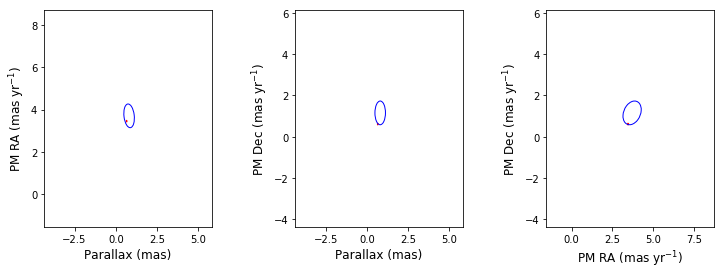

In [15]:
i = 30
p, m = pairs[i]['gaia_id1'], pairs[i]['gaia_id2']
plot_xs(hosts[hosts['source_id'] == p], all_matches[all_matches['source_id'] == m])
print(pairs[i]['chisq'])

In [12]:
pairs[(pairs['chisq'] < 16.) & (pairs['gmag2'] < 18.)]

kepid1,gaia_id1,gaia_id2,gmag1,gmag2,gaia_ra1,gaia_ra2,gaia_dec1,gaia_dec2,parallax1,parallax2,pmra1,pmra2,pmdec1,pmdec2,chisq
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3866536,2076169156332573568,2076169152031202304,13.114730834960938,17.98138999938965,295.50212507132045,295.5060295458912,38.98351040813018,38.983521984987895,0.9518037310256979,0.9584169353939288,3.020725935016194,3.292166297264151,-6.77467618528218,-6.999658217983766,2.492330551147461
4138557,2100254297827579776,2100254302127407744,11.986373901367188,15.219605445861816,285.59208805945696,285.59262726152895,39.206240565870964,39.20608214072262,1.510607483923398,1.470058168100592,1.3221557870561282,1.6340511813463334,-7.602454798293522,-7.557088793772306,8.501128196716309
4446411,2100332264374236544,2100332264371155328,14.140271186828613,15.416939735412598,285.4098189604,285.4102559424053,39.528300867107326,39.528552667616836,1.2574702555054835,1.2445796832531875,-0.7059121116997367,-0.7436128913026755,1.6738338694348154,2.1117325541868404,10.678074836730957
4484356,2073302935682322048,2073302935682325760,14.258745193481445,16.526628494262695,296.4597857214509,296.46955316252763,39.57373760651273,39.5671893007462,1.4278405187284628,1.40197373328188,7.222638410945101,7.494865219708458,2.07962182410385,2.2005643368743435,8.787859916687012
5282049,2077290555100531328,2077290555109438208,15.155351638793945,14.257413864135742,293.8369187209386,293.8370434177008,40.41043073895029,40.41273186321892,0.7427234015267055,0.7159331392472282,4.145186670073241,4.34137138657153,-0.7437994666523828,-0.8936799233439358,14.29092025756836
5282051,2077290555109438208,2077290555100531328,14.257413864135742,15.155351638793945,293.8370434177008,293.8369187209386,40.41273186321892,40.41043073895029,0.7159331392472282,0.7427234015267055,4.34137138657153,4.145186670073241,-0.8936799233439358,-0.7437994666523828,14.29092025756836
5963222,2053568729179291904,2053568729179291776,13.267065048217773,14.34056568145752,292.76428311444397,292.7649165251914,41.2753621770907,41.274678468772485,0.5187896649622631,0.43792378645744523,0.5221074081994096,0.507838756469524,-0.7303462834929757,-0.6295202447873507,8.5203857421875
6422155,2104506319750394624,2104506319748626176,14.536895751953125,17.28044319152832,283.3684092904369,283.36822093534323,41.82183898746045,41.82248814468696,1.1784629459341707,1.100221377298971,0.841549302507772,0.5775640156117139,4.493802040758001,4.5277791252780055,3.391756296157837
6507427,2103947252448388608,2103947252448388992,14.3700590133667,15.410199165344238,286.50735701664314,286.5087685035134,41.92212982155551,41.922764835056796,0.6187796290844214,0.6328299639775842,-0.5302899872860625,-0.4739587889431467,6.230496659626176,6.00113653973297,8.577411651611328


(array([23., 12., 13., 11.,  7., 10., 12., 13.,  6., 11.]),
 array([ 0.24396507,  2.71512406,  5.18628305,  7.65744204, 10.12860103,
        12.59976002, 15.07091901, 17.542078  , 20.01323698, 22.48439597,
        24.95555496]),
 <a list of 10 Patch objects>)

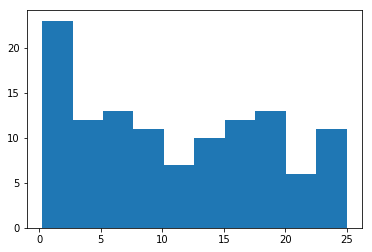

In [10]:
plt.hist(pairs['chisq'])